The program will run on cuda!
Train set size: 9500 6405 3095
Train set size: 2374 1595 779
Train set size: 2969 2000 969
(37785, 86, 72) (37785,)
[[0.         0.45349919 0.45904601 0.23604223 0.18731438]
 [0.         0.45349919 0.45904601 0.23604223 0.18731438]
 [0.         0.45349919 0.45904601 0.23604223 0.18731438]
 [0.         0.45349919 0.45904601 0.23604223 0.18731438]
 [0.         0.45349919 0.45904601 0.23604223 0.18731438]]
[[0.         0.5116252  0.62406649 0.46880499 0.28768199]
 [0.         0.5116252  0.62406649 0.46880499 0.28768199]
 [0.         0.5116252  0.62406649 0.46880499 0.28768199]
 [0.         0.5116252  0.62406649 0.46880499 0.28768199]
 [0.         0.5116252  0.62406649 0.46880499 0.28768199]]
(37785, 86, 72) (37785,)
[18619. 14076. 54479. ... 16657.  6871. 15423.]
{0.0: 2000, 1.0: 969}


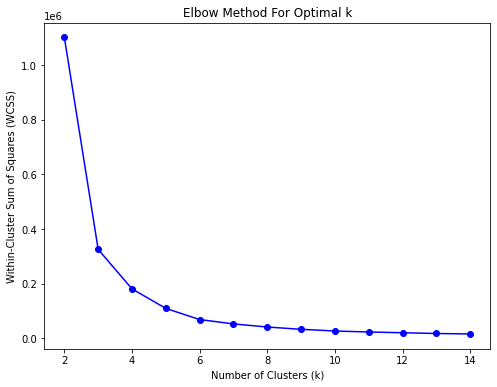

In [5]:
from models.encoder import QCLR_Classifier
from tasks.fine_tuning import finetune_eval
from config_files.ASAN_Configs import Config as Configs
import pickle
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import copy
import sklearn
from sklearn.cluster import KMeans
from utils import seed_everything

configs = Configs()
RANDOM_SEED = configs.RANDOM_SEED
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
working_directory = configs.working_directory
dataset_save_path = working_directory
if not os.path.exists(working_directory):
    os.makedirs(working_directory)

logging_directory = configs.logging_directory
if not os.path.exists(logging_directory):
    os.makedirs(logging_directory)

RANDOM_SEED = configs.RANDOM_SEED
seed_everything(RANDOM_SEED)

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Set the GPU 0 to use
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The program will run on {device}!")


def adjust_sequence_length(x_i, y_true, seq_length, x_id, min_length=3,
                              multiplier_0=2, multiplier_1=3, seed=42):
    y_true = y_true.squeeze()
    batch_size, max_seq_length, feature_dim = x_i.shape

    # Finding indexes by class (mortality)
    class_0_indices = np.where(y_true == 0)[0]
    class_1_indices = np.where(y_true == 1)[0]

    # Set the number of augmented data
    num_aug_class_0 = len(class_0_indices) * (multiplier_0 - 1)
    num_aug_class_1 = len(class_1_indices) * (multiplier_1 - 1)

    # Extract data for each class (mortality)
    x_i_class_0 = x_i[class_0_indices]
    x_i_class_1 = x_i[class_1_indices]
    seq_length_class_0 = seq_length[class_0_indices]
    seq_length_class_1 = seq_length[class_1_indices]
    x_id_class_0 = x_id[class_0_indices]
    x_id_class_1 = x_id[class_1_indices]

    # Performing per-class augmentation
    augmented_sequences_0, random_lengths_0, augmented_x_id_0 = augment_class(
        x_i_class_0, seq_length_class_0, x_id_class_0, num_aug_class_0,
        min_length, seed)
    augmented_sequences_1, random_lengths_1, augmented_x_id_1 = augment_class(
        x_i_class_1, seq_length_class_1, x_id_class_1, num_aug_class_1,
        min_length, seed)

    # Combine original and augmented data
    augmented_x_i = np.concatenate(
        [x_i, augmented_sequences_0, augmented_sequences_1], axis=0)
    augmented_y_true = np.concatenate(
        [y_true, np.zeros(num_aug_class_0, dtype=y_true.dtype),
         np.ones(num_aug_class_1, dtype=y_true.dtype)], axis=0)
    augmented_x_id = np.concatenate([x_id, augmented_x_id_0, augmented_x_id_1],
                                    axis=0)
    augmented_x_seq = np.concatenate(
        [seq_length, random_lengths_0, random_lengths_1], axis=0)

    return augmented_x_i, augmented_y_true, augmented_x_id, augmented_x_seq


def augment_class(x_i_class, seq_length_class, x_id_class, num_aug, min_length,
                  seed):
    """
    Augment time series data for a class (mortality).
    """
    batch_size_class = x_i_class.shape[0]
    feature_dim = x_i_class.shape[2]

    # An array to store the sequence to be augmented
    augmented_sequences = np.zeros((num_aug, x_i_class.shape[1], feature_dim))
    random_lengths = np.zeros(num_aug, dtype=np.int32)
    augmented_x_id = np.zeros(num_aug, dtype=x_id_class.dtype)

    for i in range(num_aug):
        # Select a sample at random
        batch_index = np.random.randint(0, batch_size_class)
        actual_length = seq_length_class[batch_index]

        if actual_length < min_length:
            # If sequence length is less than min_length - decrease length by one
            start_value = x_i_class[batch_index, 0:1, :]
            end_value = x_i_class[batch_index, actual_length - 1:actual_length,
                        :]
            if actual_length > 2:
                middle_indices = np.arange(1, actual_length - 1)
                selected_index = np.random.choice(middle_indices)
                middle_value = x_i_class[batch_index,
                               selected_index:selected_index + 1, :]
                adjusted_seq = np.concatenate(
                    (start_value, middle_value, end_value), axis=0)
            else:
                adjusted_seq = np.concatenate((start_value, end_value), axis=0)
            random_length = adjusted_seq.shape[0]
        else:
            # Choose a random length (throw an exception if min_length and max_length_for_sample are equal or min_length is greater)
            max_length_for_sample = max(min_length, actual_length - 1)
            if min_length >= max_length_for_sample:
                random_length = min_length
            else:
                random_length = np.random.randint(min_length,
                                                  max_length_for_sample + 1)
            random_lengths[i] = random_length

            # Sequence selection (always includes first and last values, and randomly selects from the middle)
            start_value = x_i_class[batch_index, 0:1, :]
            end_value = x_i_class[batch_index, actual_length - 1:actual_length,
                        :]
            num_middle_values = random_length - 2

            if num_middle_values > 0:
                possible_indices = np.arange(1, actual_length - 1)
                selected_indices = np.sort(
                    np.random.choice(possible_indices, num_middle_values,
                                     replace=False))
                middle_values = x_i_class[batch_index, selected_indices, :]
            else:
                middle_values = np.empty((0, feature_dim))

            adjusted_seq = np.concatenate(
                (start_value, middle_values, end_value), axis=0)

        augmented_sequences[i, :adjusted_seq.shape[0], :] = adjusted_seq
        random_lengths[i] = adjusted_seq.shape[0]
        augmented_x_id[i] = x_id_class[batch_index]

    return augmented_sequences, random_lengths, augmented_x_id

with open('/home/hpcmate/workspace/drpath4y/data/asan_1109_fold_'+str(1)+'.pkl', 'rb') as f:
    fold_data = pickle.load(f)

print("Train set size:", len(fold_data['X_train']), (fold_data['y_train']==0).sum(), (fold_data['y_train']==1).sum())
print("Train set size:", len(fold_data['X_val']), (fold_data['y_val']==0).sum(), (fold_data['y_val']==1).sum())
print("Train set size:", len(fold_data['X_test']), (fold_data['y_test']==0).sum(), (fold_data['y_test']==1).sum())

X_train = fold_data['X_train']
X_val = fold_data['X_val']
X_test = fold_data['X_test']

y_train = fold_data['y_train']
y_val = fold_data['y_val']
y_test = fold_data['y_test']

seq_train = fold_data['seq_train']
seq_val = fold_data['seq_valid']
seq_test = fold_data['seq_test']

id_train = fold_data['id_train']
id_val = fold_data['id_valid']
id_test = fold_data['id_test']


X_train, y_train, id_train, seq_train = adjust_sequence_length(X_train, y_train,
                                             seq_train.astype(np.int)+1,
                                             id_train.astype(np.int),
                                             5, 3, 6)

print(X_train.shape, y_train.shape)
print(X_train[0, :5, :5])
print(X_train[-1, :5, :5])
print(X_train.shape, y_train.shape)

y_train = np.column_stack((y_train, id_train, id_train))
y_val = np.column_stack((y_val, id_val, id_val))
y_test = np.column_stack((y_test, id_test, id_test))

RANDOM_SEED = i
model = QCLR_Classifier(input_dims=configs.input_dims,
                      output_dims=configs.output_dims,
                      depth=configs.depth,
                      p_output_dims=configs.num_classes, device=device,
                      flag_use_multi_gpu=configs.flag_use_multi_gpu)


model.load_state_dict(torch.load("QCLR_model.pt"))

''' Class ID '''
# Get patient ID (index = 1)
unique_values = np.unique(y_test[:, 1])
# Create a dictionary to map from unique values to class labels (Patient ID)
label_mapping = {val: idx for idx, val in enumerate(unique_values)}
#  Convert the original array to class labels (Patient ID)
class_labels = np.array([label_mapping[val] for val in y_test[:, 1]])
class_labels = y_test[:, 1].astype(np.int64)
print(y_test[:, 1])
unique, counts = np.unique(y_test[:, 0], return_counts=True)
print(dict(zip(unique, counts)))

X_data_all = np.concatenate([X_train, X_val, X_test], 0)
y_data_all = np.concatenate([y_train[:, 1], y_val[:, 1], y_test[:, 1]])
unique_values = np.unique(y_data_all)
class_labels = y_data_all.astype(np.int64)
y_emb_all, y_target, y_pred = finetune_eval(model, X_data_all, class_labels, num_classes=len(unique_values))

''' Statistical analysis of deceased patients (death is 1, y_true_all == 1)'''
y_true_all = np.concatenate([y_train[:, 0], y_val[:, 0], y_test[:, 0]])
idx = np.where(y_true_all==1)
latent_vectors_np = y_emb_all.cpu().numpy()
latent_vectors_np = latent_vectors_np[idx]

wcss = []
K = range(2, 15)  # Test the number of clusters from 2 to 14

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(latent_vectors_np)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.show()

        eSOFA_AUC                     eSOFA_SUM                    
             mean       std    median      mean       std    median
Cluster                                                            
0        1.612799  1.456898  1.308765  1.780530  1.573865  1.412351
1        1.517953  2.326505  0.804781  1.665998  2.412688  1.005976
2        4.941312  5.518191  3.350598  5.150059  5.630982  3.470120
3        3.398267  5.101582  1.224104  3.554237  5.234953  1.408367
4        0.946157  1.085770  0.705179  1.076865  1.187781  0.806773
5        1.661981  1.357049  1.408367  1.832376  1.460212  1.609562


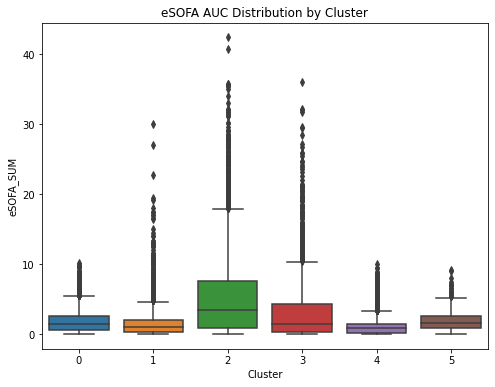

ANOVA F-statistic: 1079.6536
P-value: 0.0000e+00
Kruskal-Wallis H-statistic: 2801.6808
P-value: 0.0000e+00
Cluster 0 eSOFA SUM Mean: 1.78
Cluster 1 eSOFA SUM Mean: 1.67
Cluster 2 eSOFA SUM Mean: 5.15
Cluster 3 eSOFA SUM Mean: 3.55
Cluster 4 eSOFA SUM Mean: 1.08
Cluster 5 eSOFA SUM Mean: 1.83


In [11]:
''' Set optimal K '''
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(latent_vectors_np)

eSOFA_arr = X_data_all[:, :, -16]
eSOFA_arr = eSOFA_arr[idx]
sequence_lengths = np.concatenate(
    [seq_train, seq_val.astype(np.int) + 1, seq_test.astype(np.int) + 1],
    0).astype(np.int)
sequence_lengths = sequence_lengths[idx]
eSOFA_auc = []
for i in range(len(eSOFA_arr)):
    # Extract original time series data
    scores = eSOFA_arr[i, :sequence_lengths[i]]

    # Treat the time axis as the index of the data point
    time_steps = np.arange(len(scores))

    # AUC
    area = np.trapz(y=scores, x=time_steps)
    eSOFA_auc.append(area)

eSOFA_auc = np.array(eSOFA_auc)

def summarize_eSOFA(eSOFA_array, seq_lengths, method="mean"):
    """
    Summarize eSOFA scores by time series length.

    Args:
        eSOFA_array (numpy.ndarray): eSOFA Score Array (num_samples, max_sequence_length).
        seq_lengths (numpy.ndarray): Time series length for each sample (num_samples,).
        method (str): Summary method ("mean", "sum").

    Returns:
        np.ndarray: Summarized eSOFA Score (num_samples,).
    """
    summarized_scores = []
    for idx, length in enumerate(seq_lengths):
        eSOFA_seq = eSOFA_array[idx, :length]  # Truncate based on time series length
        if method == "mean":
            summarized_scores.append(np.mean(eSOFA_seq))
        elif method == "sum":
            summarized_scores.append(np.sum(eSOFA_seq))
        else:
            raise ValueError("Unknown summarization method.")
    return np.array(summarized_scores)


sequence_lengths = np.concatenate(
    [seq_train, seq_val.astype(np.int) + 1, seq_test.astype(np.int) + 1],
    0).astype(np.int)[idx]
# 2. eSOFA Score Summary
eSOFA_summary_mean = summarize_eSOFA(eSOFA_arr, sequence_lengths,
                                     method="mean")  # Average
eSOFA_summary_sum = summarize_eSOFA(eSOFA_arr, sequence_lengths,
                                    method="sum")  # SUM

# Create a data frame
data = {
    'Cluster': cluster_labels,
    'eSOFA_AUC': eSOFA_auc,
    # 'eSOFA_MEAN': eSOFA_summary_mean,
    'eSOFA_SUM': eSOFA_summary_sum,
    # If you have additional clinical metrics, include them here
}

df = pd.DataFrame(data)

# Calculate per-cluster statistics
cluster_stats = df.groupby('Cluster').agg(['mean', 'std', 'median'])
print(cluster_stats)

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='eSOFA_SUM', data=df)
plt.title('eSOFA AUC Distribution by Cluster')
plt.show()

from scipy.stats import f_oneway

# Generate a list of eSOFA SUM values for each cluster
groups = [df[df['Cluster'] == i]['eSOFA_SUM'] for i in range(optimal_k)]

# Perform analysis of variance (ANOVA)
f_stat, p_value = f_oneway(*groups)

print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")

from scipy.stats import kruskal

h_stat, p_value = kruskal(*groups)

print(f"Kruskal-Wallis H-statistic: {h_stat:.4f}")
print(f"P-value: {p_value:.4e}")

for i in range(optimal_k):
    cluster_data = df[df['Cluster'] == i]
    print(
        f"Cluster {i} eSOFA SUM Mean: {cluster_data['eSOFA_SUM'].mean():.2f}")

        eSOFA_AUC                     eSOFA_SUM                    
             mean       std    median      mean       std    median
Cluster                                                            
0        1.612799  1.456898  1.308765  1.780530  1.573865  1.412351
1        1.517953  2.326505  0.804781  1.665998  2.412688  1.005976
2        4.941312  5.518191  3.350598  5.150059  5.630982  3.470120
3        3.398267  5.101582  1.224104  3.554237  5.234953  1.408367
4        0.946157  1.085770  0.705179  1.076865  1.187781  0.806773
5        1.661981  1.357049  1.408367  1.832376  1.460212  1.609562


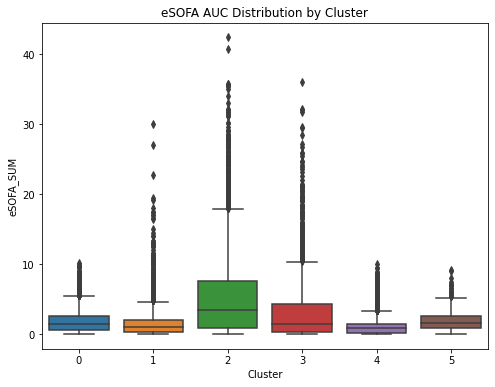

ANOVA F-statistic: 1079.6536
P-value: 0.0000e+00
Kruskal-Wallis H-statistic: 2801.6808
P-value: 0.0000e+00
Cluster 0 eSOFA SUM Mean: 1.78
Cluster 1 eSOFA SUM Mean: 1.67
Cluster 2 eSOFA SUM Mean: 5.15
Cluster 3 eSOFA SUM Mean: 3.55
Cluster 4 eSOFA SUM Mean: 1.08
Cluster 5 eSOFA SUM Mean: 1.83


In [12]:
''' Statistical analysis of Survived patients (Survival is 0, y_true_all == 0)'''
y_true_all = np.concatenate([y_train[:, 0], y_val[:, 0], y_test[:, 0]])
idx = np.where(y_true_all==0)
latent_vectors_np = y_emb_all.cpu().numpy()
latent_vectors_np = latent_vectors_np[idx]

''' Set optimal K '''
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(latent_vectors_np)

eSOFA_arr = X_data_all[:, :, -16]
eSOFA_arr = eSOFA_arr[idx]
sequence_lengths = np.concatenate(
    [seq_train, seq_val.astype(np.int) + 1, seq_test.astype(np.int) + 1],
    0).astype(np.int)
sequence_lengths = sequence_lengths[idx]
eSOFA_auc = []
for i in range(len(eSOFA_arr)):
    # Extract original time series data
    scores = eSOFA_arr[i, :sequence_lengths[i]]

    # Treat the time axis as the index of the data point
    time_steps = np.arange(len(scores))

    # AUC
    area = np.trapz(y=scores, x=time_steps)
    eSOFA_auc.append(area)

eSOFA_auc = np.array(eSOFA_auc)

def summarize_eSOFA(eSOFA_array, seq_lengths, method="mean"):
    """
    Summarize eSOFA scores by time series length.

    Args:
        eSOFA_array (numpy.ndarray): eSOFA Score Array (num_samples, max_sequence_length).
        seq_lengths (numpy.ndarray): Time series length for each sample (num_samples,).
        method (str): Summary method ("mean", "sum").

    Returns:
        np.ndarray: Summarized eSOFA Score (num_samples,).
    """
    summarized_scores = []
    for idx, length in enumerate(seq_lengths):
        eSOFA_seq = eSOFA_array[idx, :length]  # Truncate based on time series length
        if method == "mean":
            summarized_scores.append(np.mean(eSOFA_seq))
        elif method == "sum":
            summarized_scores.append(np.sum(eSOFA_seq))
        else:
            raise ValueError("Unknown summarization method.")
    return np.array(summarized_scores)


sequence_lengths = np.concatenate(
    [seq_train, seq_val.astype(np.int) + 1, seq_test.astype(np.int) + 1],
    0).astype(np.int)[idx]
# 2. eSOFA Score Summary
eSOFA_summary_mean = summarize_eSOFA(eSOFA_arr, sequence_lengths,
                                     method="mean")  # Average
eSOFA_summary_sum = summarize_eSOFA(eSOFA_arr, sequence_lengths,
                                    method="sum")  # SUM

# Create a data frame
data = {
    'Cluster': cluster_labels,
    'eSOFA_AUC': eSOFA_auc,
    # 'eSOFA_MEAN': eSOFA_summary_mean,
    'eSOFA_SUM': eSOFA_summary_sum,
    # If you have additional clinical metrics, include them here
}

df = pd.DataFrame(data)

# Calculate per-cluster statistics
cluster_stats = df.groupby('Cluster').agg(['mean', 'std', 'median'])
print(cluster_stats)

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='eSOFA_SUM', data=df)
plt.title('eSOFA AUC Distribution by Cluster')
plt.show()

from scipy.stats import f_oneway

# Generate a list of eSOFA SUM values for each cluster
groups = [df[df['Cluster'] == i]['eSOFA_SUM'] for i in range(optimal_k)]

# Perform analysis of variance (ANOVA)
f_stat, p_value = f_oneway(*groups)

print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4e}")

from scipy.stats import kruskal

h_stat, p_value = kruskal(*groups)

print(f"Kruskal-Wallis H-statistic: {h_stat:.4f}")
print(f"P-value: {p_value:.4e}")

for i in range(optimal_k):
    cluster_data = df[df['Cluster'] == i]
    print(
        f"Cluster {i} eSOFA SUM Mean: {cluster_data['eSOFA_SUM'].mean():.2f}")